## EKF Imeplementation

This Notebook contains codes to implement Extended Kalman Filter on a JetBot.

In [75]:
import os
import pickle
import cv2
import numpy as np
import math
import time

%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets.widgets as widgets
from IPython.display import display

from jetbot import bgr8_to_jpeg
from jetbot import ObjectDetector
from jetbot import Camera
from jetbot import Robot

robot = Robot()

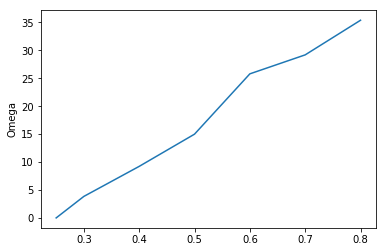

In [76]:
# Mapping between set_motor "speed" and measured wheel angular velocity "omega"
# for 0.1 second motor running time
wheel_calibration = {
    "speed": [0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    "omega": [0.0, 3.85, 9.23, 15.0, 25.8, 29.2, 35.4]
}

plt.plot(wheel_calibration["speed"],wheel_calibration["omega"])
plt.ylabel('Omega')
# fig = plt.figure(figsize=(4, 5))
plt.savefig('test.png')
plt.show()

In [107]:
def forward(wheel_speed, Rtime):

    robot.set_motors(wheel_speed, wheel_speed)
    time.sleep(Rtime)
    robot.stop()
    
    return

def control2robot(wheel_radius, axle_length):
    """ transform wheel speeds to robot motion in world frame """
    l = axle_length
    r = wheel_radius

    return np.array([[r/2, r/2],
                  [r/l, -r/l]])

def omega2speed(in_val, mapping, debug=False):
    """ Map wheel angular speed to motor speed setting based on a calibration mapping """
    
    if in_val < 0:
        sign = -1
        in_val = abs(in_val)
    else:
        sign = 1
        
    out_lower = 0
    in_lower = 0
    out_val = 0

    for i, in_upper in enumerate(mapping["omega"]):
        if debug:
            print (i, in_upper)
        if in_val < in_upper:
            out_upper = mapping["speed"][i]
            out_val = out_lower + (in_val - in_lower)/(in_upper - in_lower) \
                *(out_upper-out_lower)
            if debug:
                print("yes", out_val)
            break
        else:
            if debug:
                print("no")
            out_lower = mapping["speed"][i]
            in_lower = in_upper
            
    if out_val is 0:
        print ("Input is too high!!!", in_val)
        out_val = 0
        
    return sign*out_val


def calc_wheel_velocities(direction='L', arc_radius=0.5, min_ang_vel=3.85, \
       wheel_radius=0.0325, axle_length=0.12, debug = False):
    """ Calculate wheel velocities to generate forward arc motion of provided radius """

    radius = arc_radius
    axle = axle_length
    
    if direction is 'L':
        """ If left turn, angular velocity of right wheel should be higher.
        Set angular velocity of left wheel to minumum (e.g. 3.85--> motor setting of 0.3) """
        l_ang_vel = min_ang_vel
        r_ang_vel = (min_ang_vel*2)/(2*radius/axle-1)+min_ang_vel
    else:
        """ If right turn, angular velocity of left wheel should be higher.
        Set angular velocity of right wheel to minumum (e.g. 3.85--> motor setting of 0.3) """
        r_ang_vel = min_ang_vel    
        l_ang_vel = (min_ang_vel*2)/(2*radius/axle-1)+min_ang_vel
    
    if debug:
        print ("Left angular velocity:",l_ang_vel, " Right angular velocity:",r_ang_vel)
        T = control2robot(wheel_radius, axle_length)
        robot_velocities = np.dot(T, np.array([[r_ang_vel],[l_ang_vel]]))
        print ("Robot velocities:", robot_velocities)
        print("arc radius = ",abs(robot_velocities[0,0]/robot_velocities[1,0]))
    
    return np.array([[r_ang_vel],[l_ang_vel]])

def update_map(Mu, debug=False):
    """ Update robot position on map """
    plt.xlim([0,180])
    plt.ylim([0,180])
    
    robot_x = Mu[0,0]*100
    robot_y = Mu[1,0]*100
    robot_theta = Mu[2,0]*180/math.pi - 90 # Adjust orientation to match matplotlib
    
    if debug:
        print("(x,y):{:.1f}, {:.1f}".format(robot_x,robot_y))
        print("Orientation: {:.1f}".format(Mu[2,0]*180/math.pi))
    
    # robot = line + triangle
    plt.plot(robot_x, robot_y, marker=(2, 0, robot_theta), c='k',markersize=15, linestyle='None')
    plt.plot(robot_x, robot_y, marker=(3, 0, robot_theta), c='k',markersize=10, linestyle='None')
    
    plt.show()
    return


In [111]:
def take_circ_step(robot_params, direction, radius, debug=False, motion=True):
    
    # load robot control parameters
    start_x = robot_params["start_x"]
    start_y = robot_params["start_y"]
    wheel_radius = robot_params["wheel_radius"]
    axle_length = robot_params["axle_length"]
    motor_on_time = robot_params["motor_on_time"]
    motor_off_time = robot_params["motor_off_time"]
    min_ang_velocity = robot_params["min_ang_velocity"]
    
    """ Generate clamped wheel velocities based on turn direction and radius """
    wheel_velocities = calc_wheel_velocities(direction='L', arc_radius=radius, \
        min_ang_vel=min_ang_velocity, \
        wheel_radius=wheel_radius, axle_length=axle_length, debug = debug)
    
    """ Map wheel angular velocities to motor setting, then run motors """ 
    w_r = omega2speed(wheel_velocities[0,0],wheel_calibration) 
    w_l = omega2speed(wheel_velocities[1,0],wheel_calibration)
    if debug:
        print ("L motor:", w_l," R motor:", w_r)
    
    """ Run motor step motion """
    if motion:
        robot.set_motors(w_l, w_r)  # left, right
        time.sleep(motor_on_time)
        robot.stop()
        time.sleep(motor_off_time)
    
    return wheel_velocities

In [125]:
robot_params = {
    # pose
    "start_x": 1.25,
    "start_y": 0.75,
    "start_theta": math.pi/2,
    # physical dimensions
    "wheel_radius": 0.0325,
    "axle_length": 0.12,
    # stepwise motor control
    "motor_on_time": 0.1,  
    "motor_off_time": 0.2,
    # wheel velocity control
    "min_ang_velocity": 6.0 # Equivalent to motor speed setting of 0.3
}

control_params = {
    "num_iter": 101,
    "interval": 5,
    "debug": False,
}


(x,y):125.0, 75.0
Orientation: 90.0


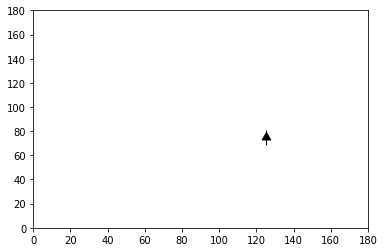

(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.0006576916606180205 0.022928601574757634 0.057352941176470586
(x,y):124.9, 77.3
Orientation: 93.3


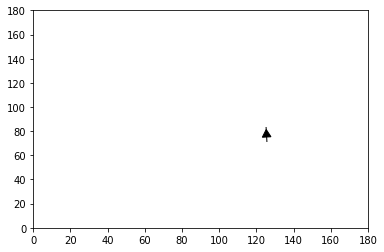

(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.0019709121902518503 0.022853201824530874 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.0032776514573289897 0.02270265027301205 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.004573612304256658 0.022477442002700767 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.005854533017827235 0.022178317601603506 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.0071162013436846475 0.021806260727840643 0.057352941176470586
(x,y):122.7, 88.5
Orientation: 109.7


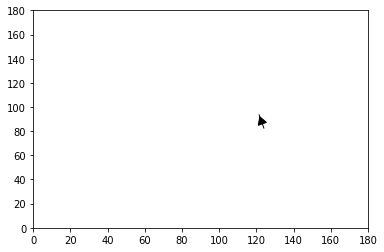

(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.008354468338146948 0.021362494874928008 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.009565262011834764 0.020848479348369156 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.010744600720238485 0.020265904466790288 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.011888606257190439 0.0196166860033981 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.012993516608183688 0.018902958886038858 0.057352941176470586
(x,y):117.3, 98.6
Orientation: 126.1


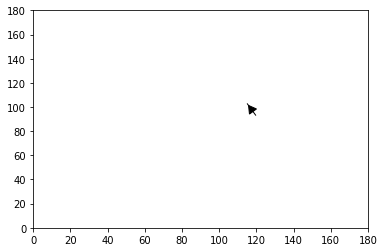

(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.01405569832160043 0.01812707017657784 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.015071658457165783 0.017291571352684044 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.01603805607233637 0.016399209917401958 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.016951713208850406 0.015452920364102951 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.017809625343311233 0.014455814526525536 0.057352941176470586
(x,y):109.3, 106.8
Orientation: 142.6


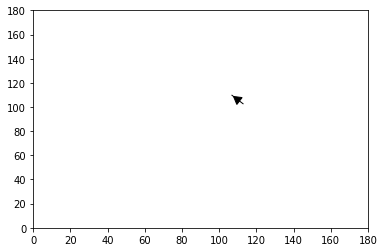

(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.018608971267436925 0.013411171345640495 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.01934712236548619 0.01232242608698968 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.020021651258351827 0.011193159043958945 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.020630339785895346 0.010027083764132217 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.02117118630127437 0.00882803483744561 0.057352941176470586
(x,y):99.3, 112.3
Orientation: 159.0


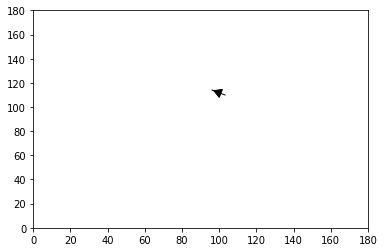

(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.021642412253274703 0.0075999552862978 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.02204246803500183 0.006346883599085685 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.022370038079698687 0.005072940449803377 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.02262404518693191 0.0037823151473778353 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.022803654064920676 0.002479251859301002 0.057352941176470586
(x,y):88.2, 114.9
Orientation: 175.4


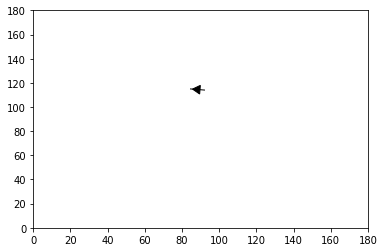

(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.022908274077358855 0.0011680356548620097 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.022937561185697883 -0.00014702158612451833 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.022891419080503163 -0.0014615953527554295 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.022769999498163652 -0.002771362724012816 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.022573701721913045 -0.004072016584509575 0.057352941176470586
(x,y):76.8, 114.1
Orientation: 191.9


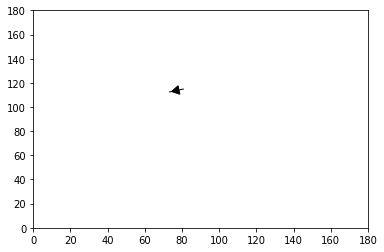

(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.022303171268803525 -0.005359279788258631 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.02195929776694987 -0.0066289192238894405 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.021543212030024475 -0.007876759735057927 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.02105628233862369 -0.009098697850274196 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.020500109940734257 -0.010290715276997453 0.057352941176470586
(x,y):66.0, 110.2
Orientation: 208.3


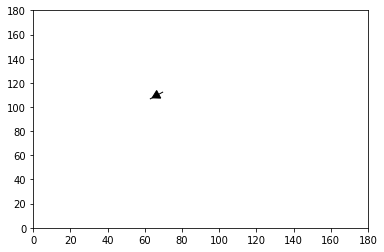

(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.01987652378609597 -0.011448892115623322 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.019187574511776707 -0.012569419749910394 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.018435527698738064 -0.013648613371455821 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.017622856421566625 -0.014682924097034223 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.01675223311587151 -0.015668950638952107 0.057352941176470586
(x,y):56.8, 103.4
Orientation: 224.7


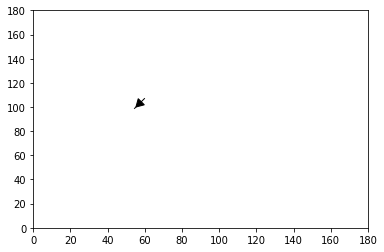

(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.01582652079009126 -0.016603450490040663 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.014848763610609873 -0.017483350586505342 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.013822176891142401 -0.018305757413567925 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.012750136519310562 -0.01906796652066949 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.011636167855176183 -0.019767471414943106 0.057352941176470586
(x,y):50.0, 94.3
Orientation: 241.2


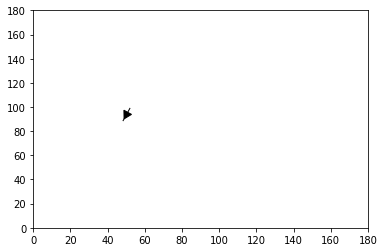

(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.010483934138242291 -0.020401971803711196 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.009297224441042529 -0.0209693811589019 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.00807994120893385 -0.02146783357851001 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.006836087427068183 -0.021895689922537456 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.005569753456742355 -0.02225154320323729 0.057352941176470586
(x,y):45.9, 83.6
Orientation: 257.6


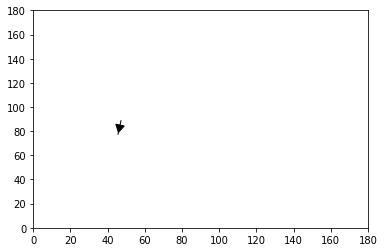

(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.00428510358441554 -0.022534223211933848 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.0029863623276269015 -0.02274280036720543 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.0016778005428459864 -0.02287658877177396 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): -0.0003637213809390083 -0.02293514846804957 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.000951553863563115 -0.02291828688491282 0.057352941176470586
(x,y):45.1, 72.2
Orientation: 274.0


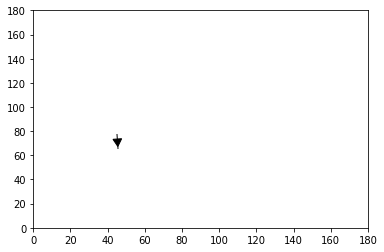

(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.002263699962861798 -0.022826059470976767 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.0035684019792219246 -0.02265876951224656 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.0048613694544646265 -0.022416967134775992 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.006138350518960456 -0.02210144749560098 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.007395145873724963 -0.021713248167898727 0.057352941176470586
(x,y):47.5, 61.0
Orientation: 290.5


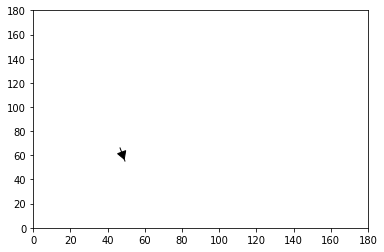

(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.008627622599638408 -0.021253645728971704 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.00983172774837815 -0.02072415156227632 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.011003501670370053 -0.020126506887301422 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.012139091035930916 -0.01946267703364084 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.013234761506782756 -0.018734844978088593 0.057352941176470586
(x,y):53.0, 51.0
Orientation: 306.9


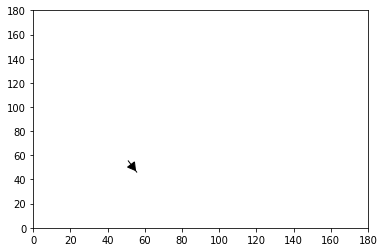

(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.01428691001626814 -0.017945404166011026 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.015292076617885054 -0.01709695064060144 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.01624695586317637 -0.016192274505900217 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.017148407671559562 -0.015234350751654226 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.017993467656350327 -0.014226329470186717 0.057352941176470586
(x,y):61.1, 42.9
Orientation: 323.3


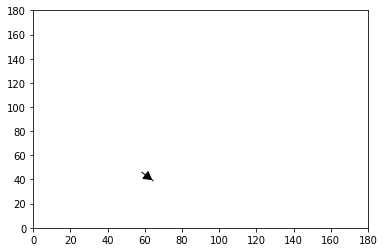

(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.018779356873025232 -0.013171525497450487 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.01950349095766435 -0.012073407512327794 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.020163488625524528 -0.010935586630024564 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.020757179501794766 -0.009761804527068742 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.021282611258783637 -0.008555921136962708 0.057352941176470586
(x,y):71.2, 37.5
Orientation: 339.7


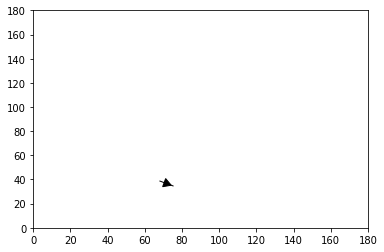

(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.02173805603606709 -0.007321901956953258 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.022122016122485735 -0.006063805007658996 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.022433228881305268 -0.004785767488439019 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.02267067090234496 -0.0034919921723850058 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.022833561367419215 -0.002186733585677425 0.057352941176470586
(x,y):82.3, 35.1
Orientation: 356.2


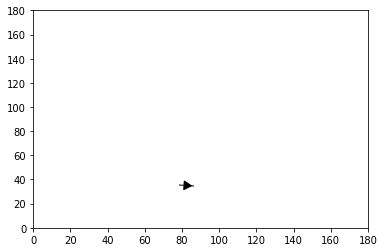

(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.022921364618025655 -0.0008742840167533128 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.022933791916835793 0.00044104059870488934 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.02287080239719567 0.0017549148705442886 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.02273260319751416 0.003063018178006427 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.022519648780096924 0.0043610488779086245 0.057352941176470586
(x,y):93.7, 36.0
Orientation: 372.6


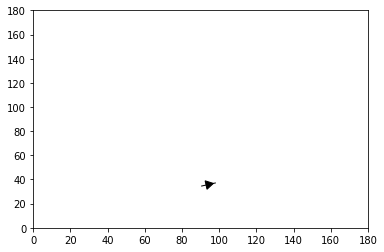

(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.02223263943666609 0.005644738450418041 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.021872518985480174 0.006909865535901449 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.02144047166762693 0.008152269816690039 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.02093791825269613 0.009367865698110923 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.020366511366637807 0.010552655743794626 0.057352941176470586
(x,y):104.4, 40.0
Orientation: 389.0


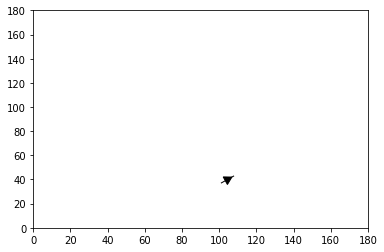

(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.01972813005717087 0.011702743821077988 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.01902487361461307 0.012814347913274028 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.018259054668451926 0.013883812556675902 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.01743319158235983 0.014907620861397276 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.01655000017265933 0.01588240607651765 0.057352941176470586
(x,y):113.5, 46.9
Orientation: 405.5


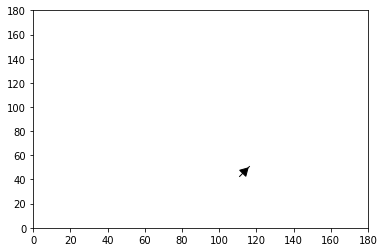

(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.015612384777474909 0.016804962661502644 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.014623428705937958 0.01767225682749034 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.013586384098853311 0.01848143651377927 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.012504661234169845 0.019229840766711484 0.057352941176470586
(v,omega): [[0.22941]
 [0.57353]]
(dx,dy,dtheta): 0.011381817312423515 0.0199150084901073 0.057352941176470586
(x,y):120.3, 56.2
Orientation: 421.9


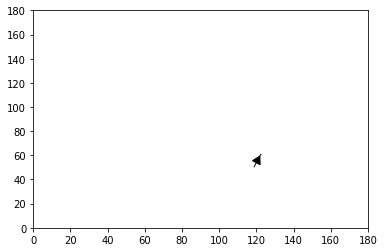

In [127]:
LARGE = 1e6
t_delta = 0.1  # motor on time
dt = 0.1
R_t = np.zeros((3,3))  # Assume zero control noise for now

diag_dir = 'diagnostics'

debug = False
np.set_printoptions(precision=5)

wheel_radius = robot_params["wheel_radius"]
axle_length = robot_params["axle_length"]
T = control2robot(wheel_radius,axle_length)

# robot's initial pose
x = robot_params["start_x"]
y = robot_params["start_y"]
theta = robot_params["start_theta"]

# landmark's coordinates
landmarks = ['cup', 'horse']

num_iter = control_params["num_iter"]
interval = control_params["interval"]

""" Initialize Mu and Sigma """
# Initialize Mu
Mu = np.array([[x],[y],[theta]])
for object in enumerate(landmarks):
    Mu = np.vstack((Mu,np.array([[0],[0]])))
N = Mu.shape[0]   # N=3+2n, n=num of landmarks

# Initialize Sigma - For Σ_mm, infinity (large num) along the diagonal and zero everywhere else 
Sigma = np.zeros((N,N))
Sigma[3:,3:] = np.eye(N-3)*LARGE

if debug:
    print(Mu)
    print(Sigma)

# Place robot (and landmark)on map
update_map(Mu, debug=True)

""" Robot moves stepwise in a circle """
for i in range(num_iter):
    
    # Take 1 circular step
    wheel_velocities = take_circ_step(robot_params, 'L', 0.4, debug=False, motion=False)
    robot_velocities = np.dot(T,wheel_velocities)   # convert to (v,omega)

    if debug:
        print("Step: ", i+1)
        print("(w_r,w_l): {}".format(wheel_velocities))
        print("(v,omega): {}".format(robot_velocities))
        
    print("(v,omega): {}".format(robot_velocities))

    """ EKF Prediction Step """
    v = robot_velocities[0,0]
    w = robot_velocities[1,0]
    arc_radius = v/w   # arc radius 
    
    """
    x_delta = v*t_delta*math.cos(theta)
    y_delta = v*t_delta*math.sin(theta)
    """
    theta = Mu[2,0]
    x_delta = arc_radius*(math.sin(theta+w*t_delta)-math.sin(theta))
    y_delta = arc_radius*(math.cos(theta)-math.cos(theta+w*t_delta))
    theta_delta = w*t_delta

    F = np.zeros((3,N))
    F[0:3,0:3] = np.eye(3)

    # Implement Mu_t = g(Mu_t-1, u_t) 
    Mu = Mu + np.dot(F.T, np.array([[x_delta],[y_delta],[theta_delta]]))

    # Calculate G_t
    d_x_delta = arc_radius*(math.cos(theta+w*t_delta)-math.cos(theta))
    d_y_delta = arc_radius*(-math.sin(theta)+math.sin(theta+w*t_delta))
    G_x_t = np.array([[0,0,d_x_delta],[0,0,d_y_delta],[0,0,0]])
    G_t = np.eye(N)+ np.dot(np.dot(F.T, G_x_t),F)

    # Calculate Sigma_t = G_t.Sigma_t-1.G_t^T + F^T.R_t.F
    Sigma = np.dot(np.dot(G_t, Sigma),G_t.T) + np.dot(np.dot(F.T, R_t),F)
    
    print("(dx,dy,dtheta):",x_delta,y_delta,theta_delta)
    if debug:
        print("(dx,dy,dtheta):",x_delta,y_delta,theta_delta)
        print("Mu:",Mu)
        np.set_printoptions(suppress=True)
        print("G:",G_t)
        print("Sigma:",Sigma)
    
    # Update robot and landmark on map
    if i%interval==0:
        update_map(Mu, debug=True)

In [ ]:
# Make approx 3 to 4 circular runs - 300 steps
for i in range(3):
    take_circ_step(robot_params, 'L', 0.5, debug=False)

In [30]:
robot.stop()

In [102]:
Mu

array([[1.24018],
       [1.19304],
       [2.45716],
       [0.     ],
       [0.     ],
       [0.     ],
       [0.     ]])

In [106]:
Mu += np.dot(F.T, np.array([[x_delta],[y_delta],[theta_delta]]))

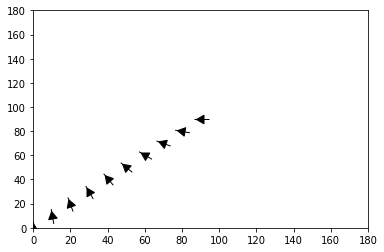

In [97]:
x = [0,10,20,30,40,50,60,70,80,90]

for i in x:
    plt.plot(i, i, marker=(2, 0, i), c='k',markersize=15, linestyle='None')
    plt.plot(i, i, marker=(3, 0, i), c='k',markersize=10, linestyle='None')
"""
plt.plot(x, y, fillstyle="none", **filled_marker_style)
"""

plt.xlim([0,180])
plt.ylim([0,180])

plt.show()


In [122]:
for i in range(18):
    theta = math.pi/(18-i+1)
    print(theta, math.sin(theta+0.057353)-math.sin(theta))

0.16534698176788384 0.05626913948353665
0.17453292519943295 0.05616520134464176
0.18479956785822313 0.056043427196913076
0.19634954084936207 0.055899371057812786
0.20943951023931953 0.055727093825776924
0.2243994752564138 0.05551851525397622
0.241660973353061 0.05526241163181744
0.2617993877991494 0.05494281908848597
0.28559933214452665 0.05453640277956778
0.3141592653589793 0.05400794990310209
0.3490658503988659 0.053302288803685705
0.39269908169872414 0.05232899797089824
0.4487989505128276 0.05093153766428349
0.5235987755982988 0.048819813189689254
0.6283185307179586 0.04540766271047081
0.7853981633974483 0.03936981770057113
1.0471975511965976 0.027236834196859072
1.5707963267948966 -0.0016442325233999577
